## import

In [1]:
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.controller.trainer import MultiOutputClassificationTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.plot import plot_grids
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.pspnet import PSPLoss, PSPNet
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/pspnet")
data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 16
IMAGE_SIZE = 224

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)

In [6]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)


In [7]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    transform=preprocess,
)

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

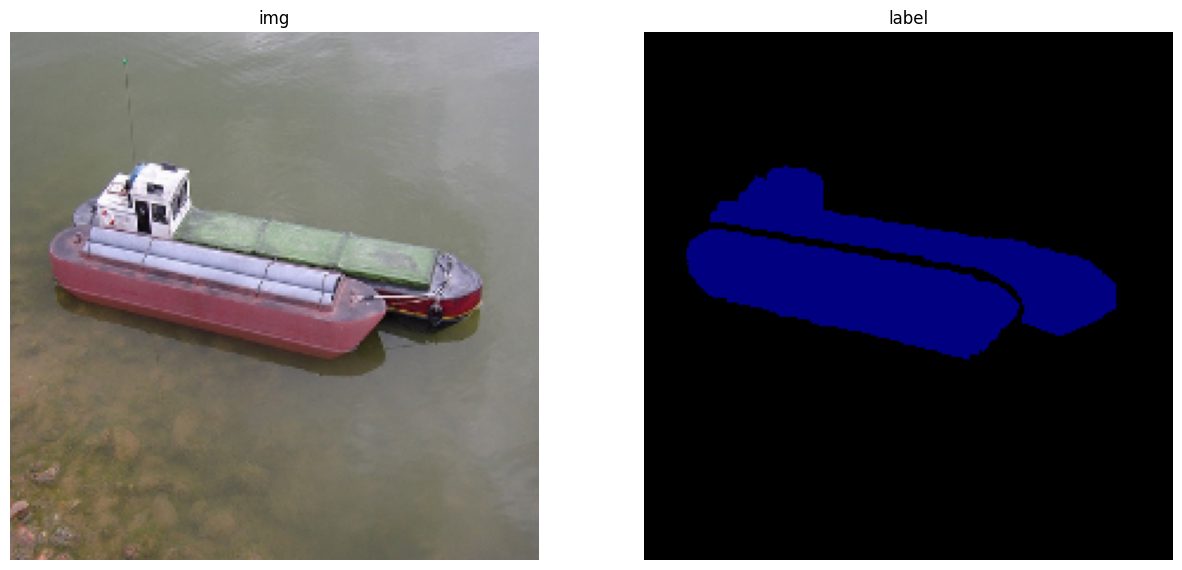

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [10]:
model = PSPNet(hidden_dim=2048, output_size=20 + 1, frozen_backbone=False).to(DEVICE)

In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
PSPNet                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Sequential: 3-1                        9,536
│    │    └─Sequential: 3-2                        215,808
│    │    └─Sequential: 3-3                        1,219,584
│    │    └─Sequential: 3-4                        7,098,368
│    │    └─Sequential: 3-5                        14,964,736
│    │    └─AdaptiveAvgPool2d: 3-6                 --
│    └─ImageNetNormalization: 2-2                  --
├─PyramidPool2d: 1-2                               --
│    └─ModuleList: 2-3                             --
│    │    └─Sequential: 3-7                        1,049,600
│    │    └─Sequential: 3-8                        1,049,600
│    │    └─Sequential: 3-9                        1,049,600
│    │    └─Sequential: 3-10                       1,049,600
├─Sequential: 1-3  

# train

In [12]:
EPOCHS = 30

In [13]:
trainer = MultiOutputClassificationTrainer(EPOCHS, DEVICE)

In [14]:
criterion = PSPLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


epoch 1 : 0.10622582023779115


100%|██████████| 182/182 [00:56<00:00,  3.20it/s]


epoch 2 : 0.08389686185170661


100%|██████████| 182/182 [00:57<00:00,  3.15it/s]


epoch 3 : 0.07616526348987124


100%|██████████| 182/182 [00:57<00:00,  3.15it/s]


epoch 4 : 0.07080291459275471


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 5 : 0.06852506690627926


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 6 : 0.06436880620626304


100%|██████████| 182/182 [00:58<00:00,  3.12it/s]


epoch 7 : 0.06157457885833887


100%|██████████| 182/182 [00:58<00:00,  3.11it/s]


epoch 8 : 0.060019723763996426


100%|██████████| 182/182 [00:57<00:00,  3.16it/s]


epoch 9 : 0.05602973591085974


100%|██████████| 182/182 [00:57<00:00,  3.18it/s]


epoch 10 : 0.05373072405192223


100%|██████████| 182/182 [00:56<00:00,  3.20it/s]


epoch 11 : 0.05267371617994466


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 12 : 0.049196632947404305


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 13 : 0.05070729005140263


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 14 : 0.047914120399362436


100%|██████████| 182/182 [00:57<00:00,  3.18it/s]


epoch 15 : 0.04953995490303406


100%|██████████| 182/182 [00:57<00:00,  3.18it/s]


epoch 16 : 0.041447374396599256


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 17 : 0.038663886446546725


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 18 : 0.03750172017940453


100%|██████████| 182/182 [00:56<00:00,  3.20it/s]


epoch 19 : 0.03659254732122133


100%|██████████| 182/182 [00:56<00:00,  3.20it/s]


epoch 20 : 0.03576739622627968


100%|██████████| 182/182 [00:56<00:00,  3.19it/s]


epoch 21 : 0.03532751121527546


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 22 : 0.034730989107309464


100%|██████████| 182/182 [00:56<00:00,  3.20it/s]


epoch 23 : 0.03404888531172669


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 24 : 0.03359792820577111


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 25 : 0.033271150929587226


100%|██████████| 182/182 [00:56<00:00,  3.19it/s]


epoch 26 : 0.032314128457353666


100%|██████████| 182/182 [00:56<00:00,  3.20it/s]


epoch 27 : 0.03229667828674172


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 28 : 0.03245562995569064


100%|██████████| 182/182 [00:57<00:00,  3.19it/s]


epoch 29 : 0.03221606654575565


100%|██████████| 182/182 [01:00<00:00,  2.99it/s]

epoch 30 : 0.032428459561133126


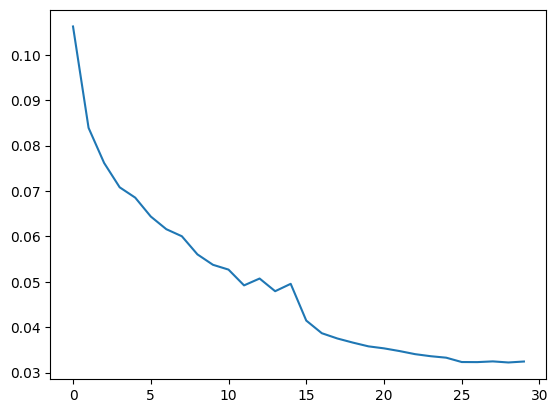

In [24]:
plt.plot(training_loss)
# plt.plot(torch.arange(len(training_loss)), torch.arange(len(training_loss)).mul(-0.05/2).exp())

In [27]:
model_path = artifacts_path.joinpath('pspnet.pth')

In [28]:
torch.save(model.state_dict(), model_path)

In [29]:
get_file_size(model_path)

'187.11MiB'

# inference

In [30]:
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

In [31]:
# for inference, be cautious if you have not saved trained weights
if hasattr(model, "aux"):
    del model.aux

In [32]:
model_path = artifacts_path.joinpath('pspnet.inference.pth')

In [33]:
torch.save(model.state_dict(), model_path)

In [34]:
get_file_size(model_path)

'178.08MiB'

In [18]:
test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [19]:
test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

### dice coef

In [21]:
from torchmetrics.classification import jaccard

In [22]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 40/40 [00:07<00:00,  5.48it/s]


In [23]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.83 
bicycle        : 0.41 
bird           : 0.9  
boat           : 0.83 
bottle         : 0.81 
bus            : 0.91 
car            : 0.85 
cat            : 0.89 
chair          : 0.55 
cow            : 0.82 
diningtable    : 0.87 
dog            : 0.77 
horse          : 0.76 
motorbike      : 0.8  
person         : 0.84 
pottedplant    : 0.54 
sheep          : 0.86 
sofa           : 0.81 
train          : 0.9  
tvmonitor      : 0.86 
----------------------
total          : 0.79 


### for image in dataset

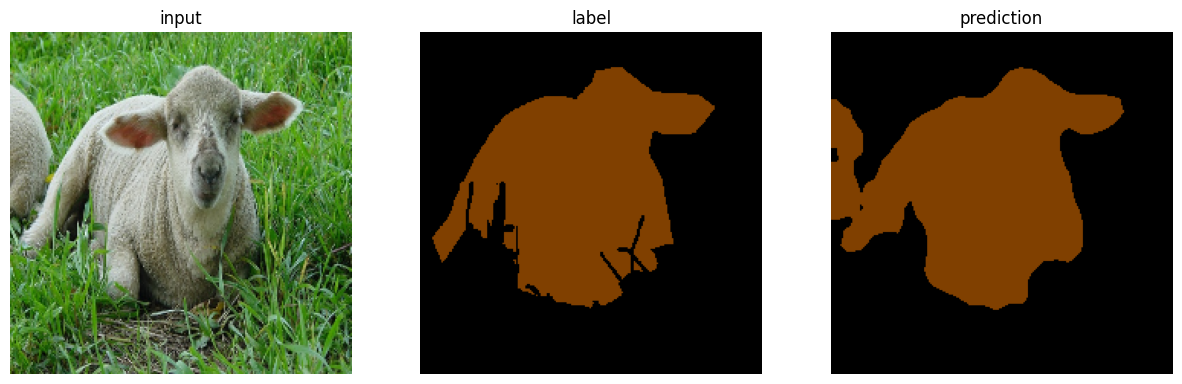

In [25]:
interest_pic = 11

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image you like

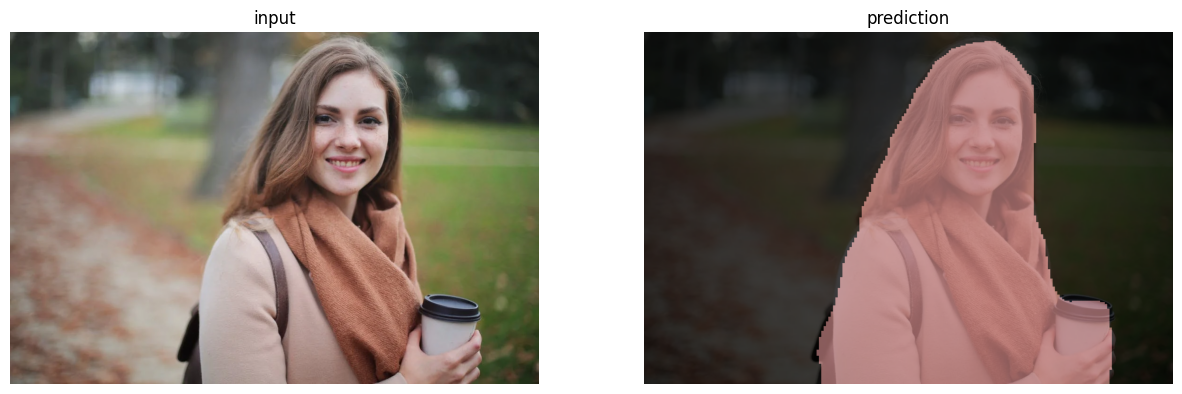

In [26]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )